In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import matplotlib.lines as mlines
import matplotlib.patheffects as path_effects
from matplotlib.lines import Line2D
from matplotlib import cm

import plotly.express as px
import networkx as nx
from pyproj import Proj, transform 
from mpl_toolkits.basemap import Basemap as Basemap

import geopandas as gpd  # gpd.__version__  # gpd.show_versions()
import shapely
import shapely.geometry as geom
from shapely.geometry import LineString

# %load_ext watermark
# %watermark --iversions
# %watermark -v -m -p numpy,pandas,mpl_toolkits.basemap,pyproj,pyshp

In [2]:
from map_function import read_csv, read_shp, flow_map, flow_map1

In [3]:
df = read_csv('with nodes coordinates.csv')
df1 = read_shp('new1/anpr_epsg4326.shp')  #df1 = pd.read_csv('anpr.csv') # try using geopandas convert to epsg4326 later
df

(2211, 9)


,OBJECTID,length_unit,magnitude,coord_x1,coord_y1,name_x1y1,coord_x2,coord_y2,name_x2y2
0,1,364.48618,3384.0,0.101681,52.159237,1a,0.098907,52.158174,1b
1,2,287.94352,3384.0,0.098907,52.158174,2a,0.096869,52.157197,2b
2,3,21.26571,826.0,0.102216,52.160129,3a,0.102196,52.160013,3b
3,4,84.85154,3797.0,0.102149,52.159589,4a,0.101681,52.159237,4b
4,5,77.06397,826.0,0.102196,52.160013,5a,0.102149,52.159589,5b
...,...,...,...,...,...,...,...,...,...
2206,2207,19.55846,2.0,0.049261,52.293250,2207a,0.049420,52.293205,2207b
2207,2208,0.13286,5.0,0.055653,52.291566,2208a,0.055654,52.291566,2208b
2208,2209,177.76883,3.0,0.054186,52.291953,2209a,0.055653,52.291566,2209b
2209,2210,17.90372,1.0,0.049420,52.293205,2210a,0.049568,52.293166,2210b


In [4]:
title = 'Cambridge Road Map'

date = '22 Aug'
time = 'xxpm'
vehicle = 'car'
location = 'Cambridge'

# subtitle = location+' '+date+' '+time +' '+vehicle

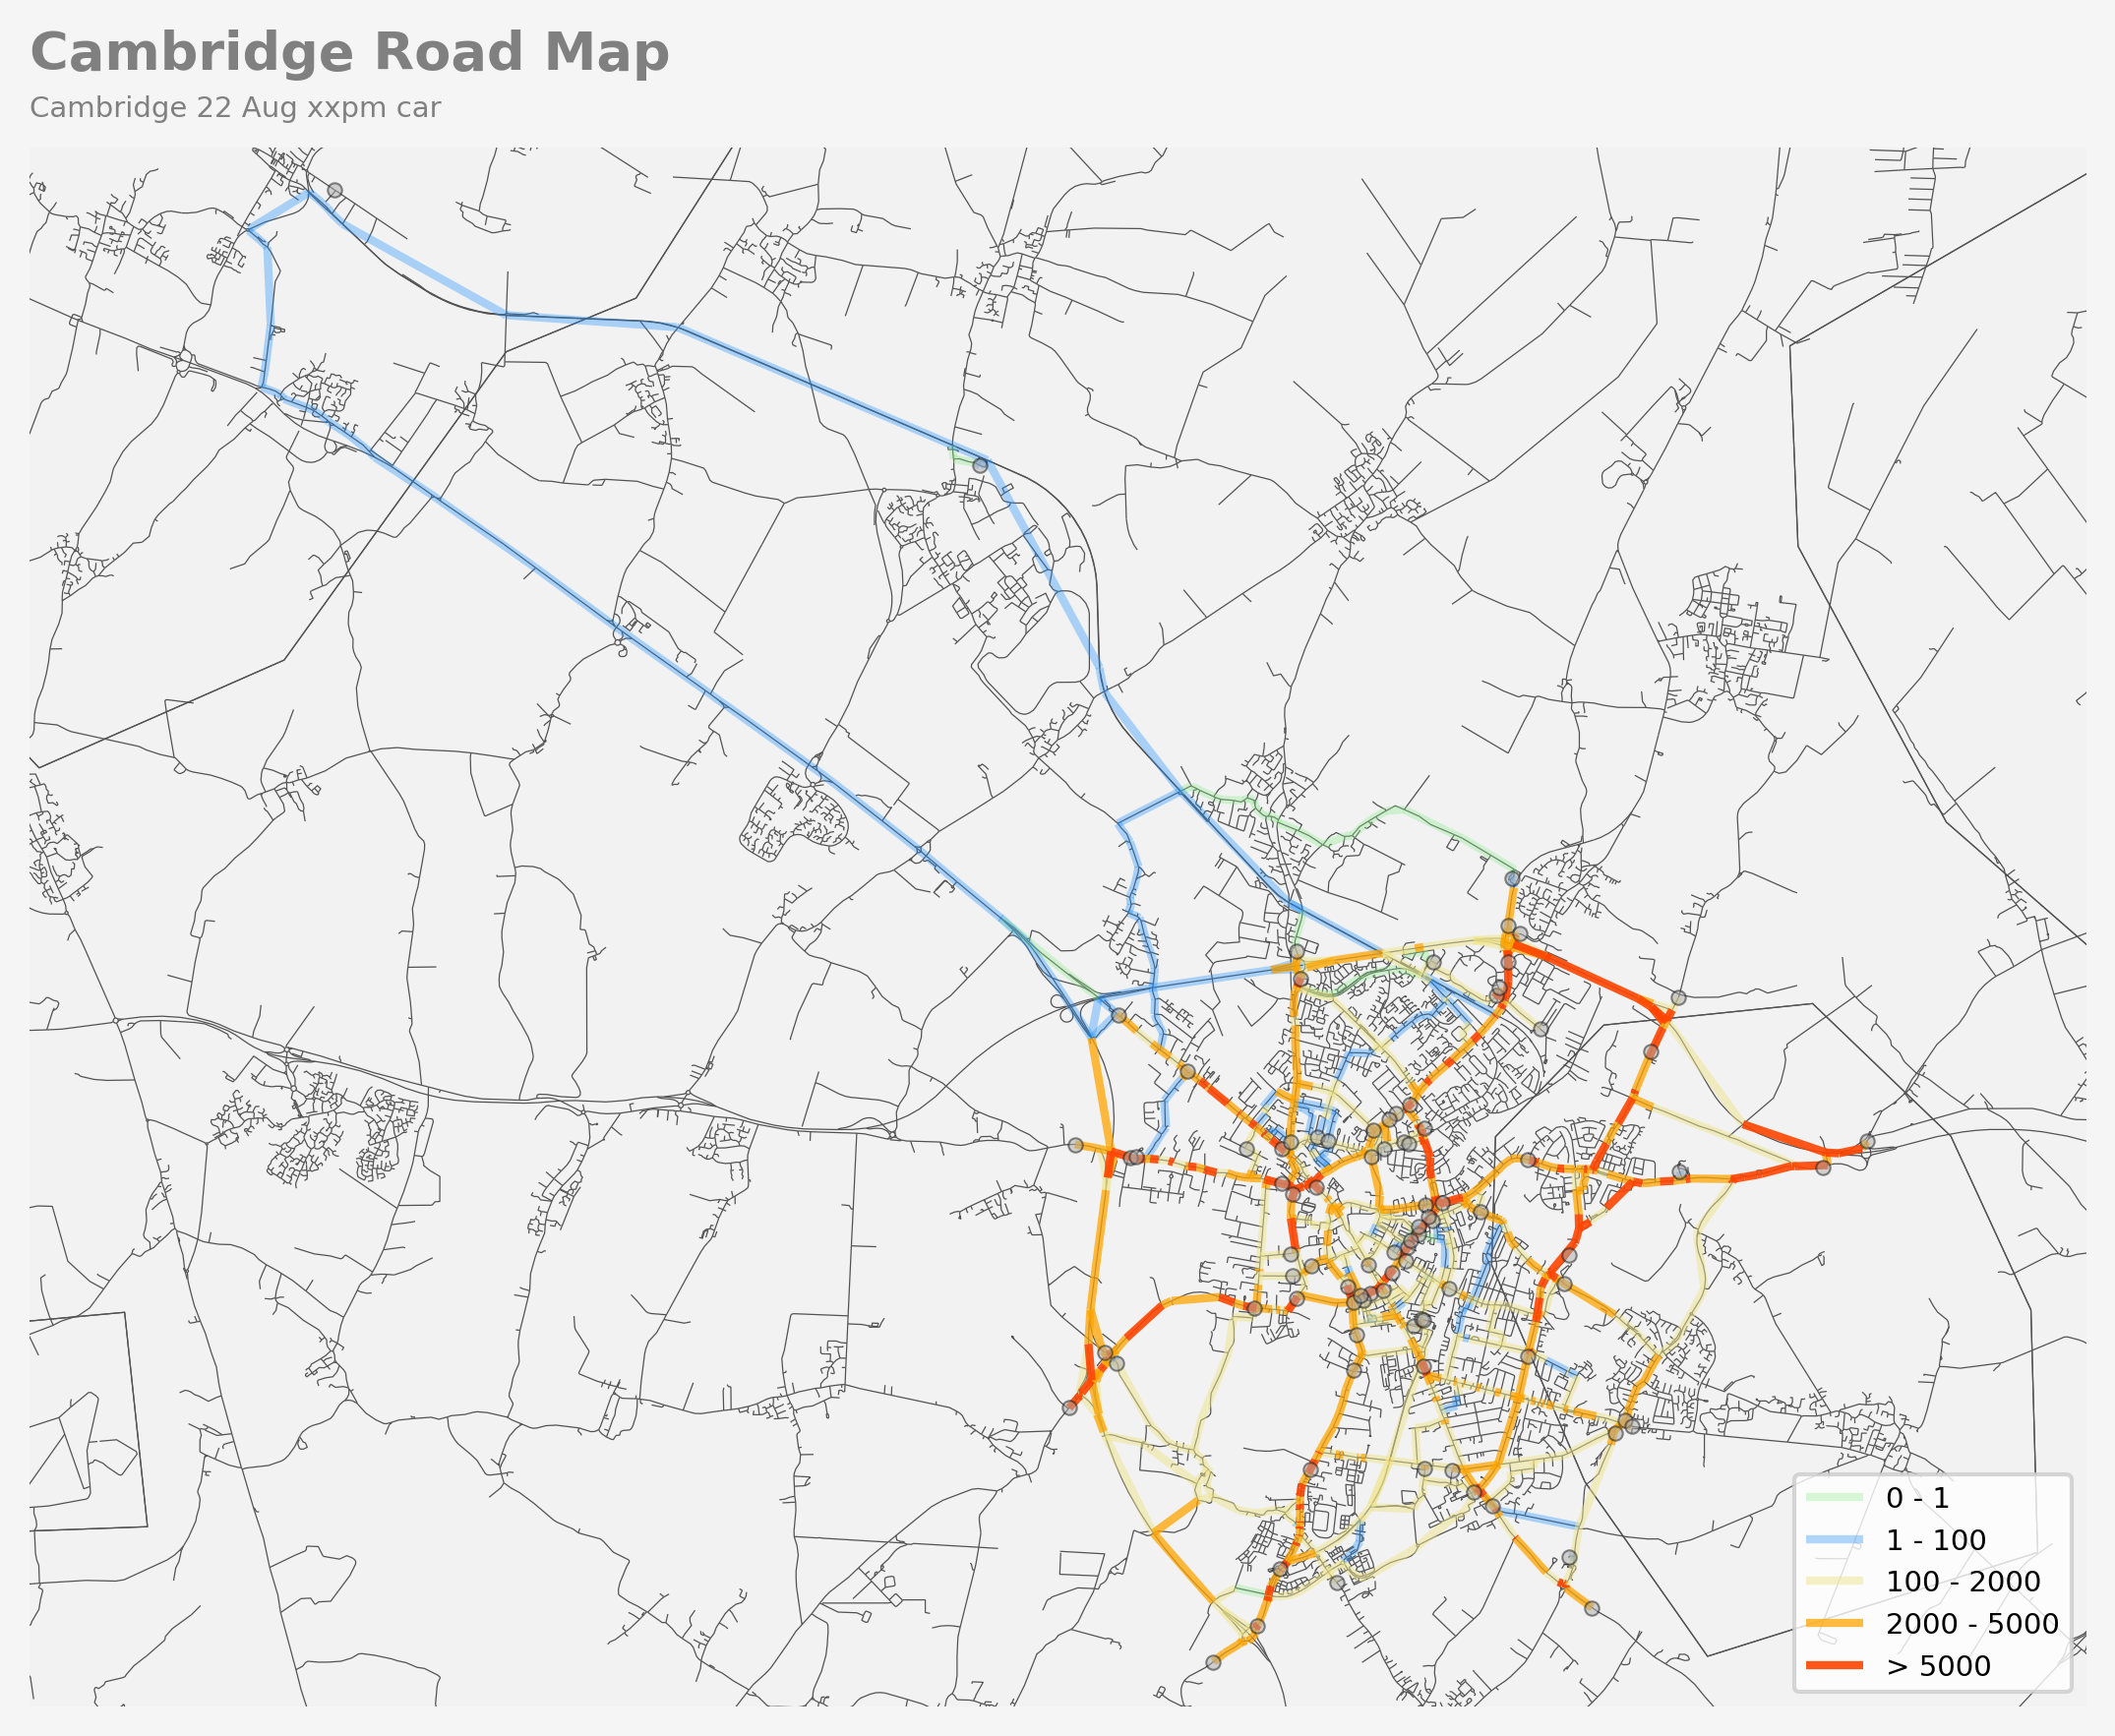

In [5]:
flow_map(title,date,time,vehicle,location)

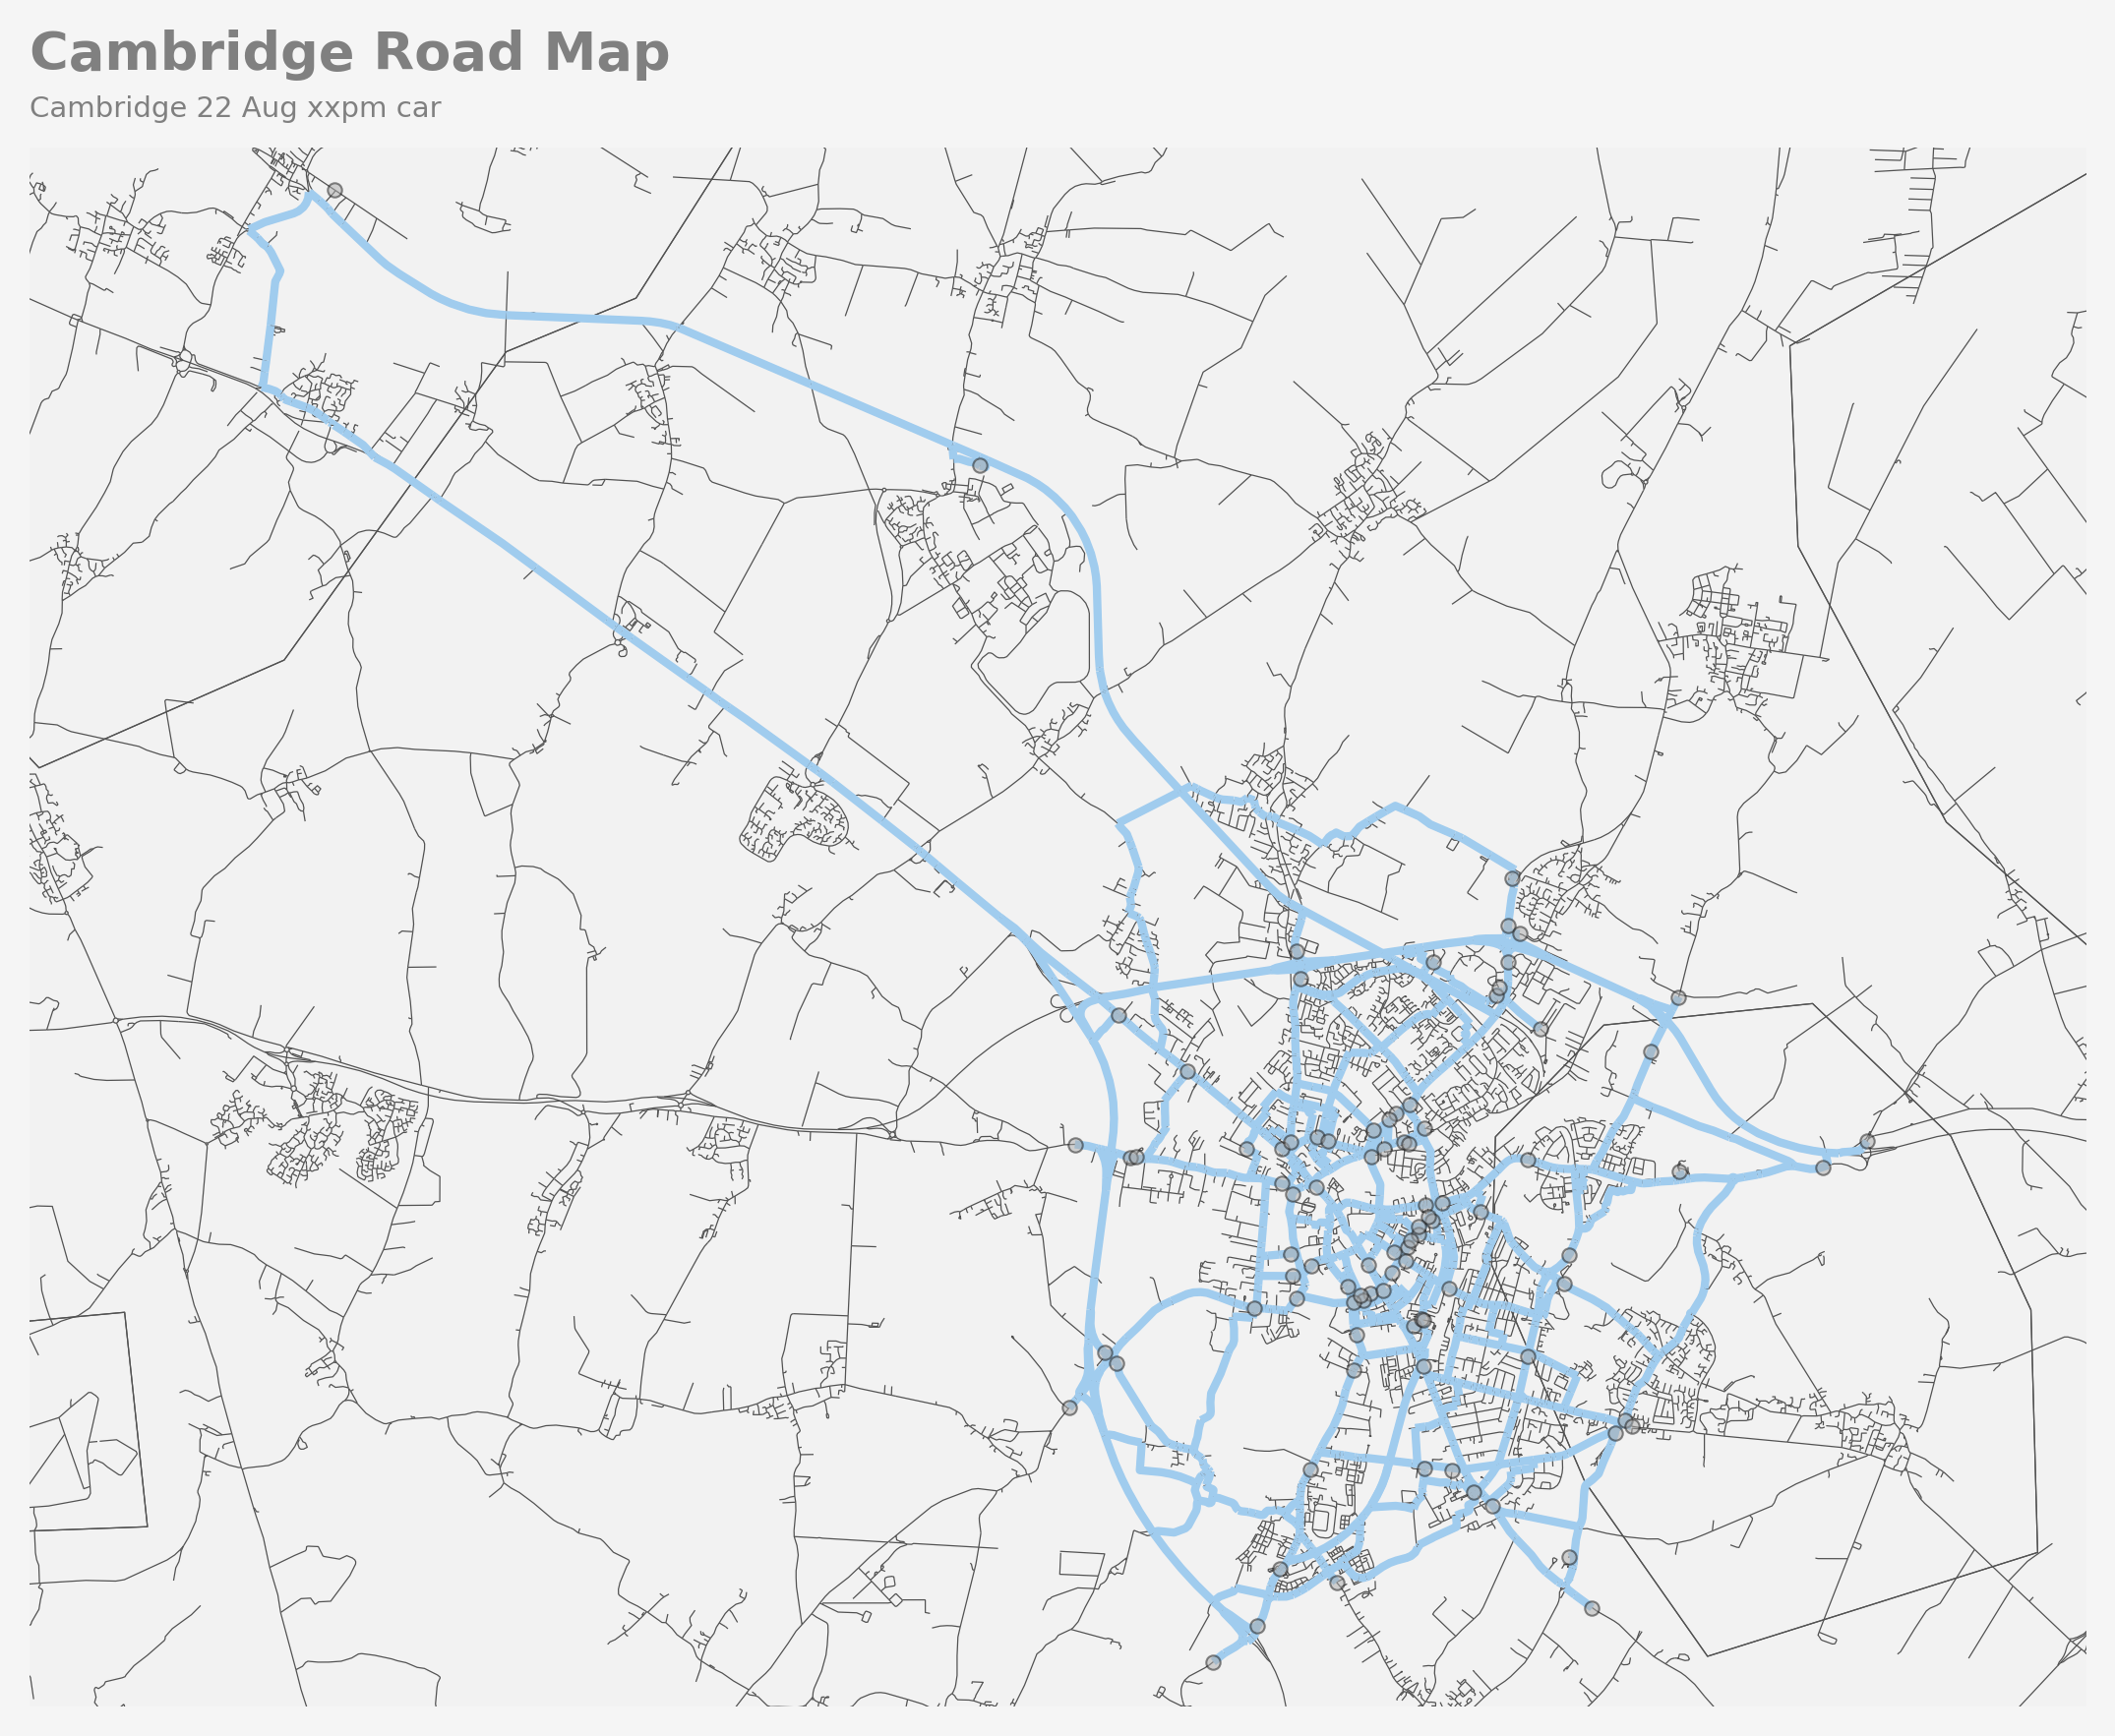

In [6]:
flow_map1(title,date,time,vehicle,location)

In [7]:
# name1='name_x1y1'
# name2='name_x2y2'
# df_name1 = df[[name1,'coord_x1','coord_y1']].rename(columns={name1:'name', 'coord_x1':'long', 'coord_y1':'lat'}).drop_duplicates()
# df_name2 = df[[name2,'coord_x2','coord_y2']].rename(columns={name2:'name', 'coord_x2':'long', 'coord_y2':'lat'}).drop_duplicates()
# df_name = pd.concat([df_name1, df_name2], ignore_index=True, sort=False).drop_duplicates()

# m = Basemap(projection='merc', resolution='i', #epsg=epsg,
# llcrnrlon=df_name['long'].min()-0.08, 
# llcrnrlat=df_name['lat'].min()-0.01, 
# urcrnrlon=df_name['long'].max()+0.08, 
# urcrnrlat=df_name['lat'].max()+0.01,
# lat_ts=df_name['lat'].mean(),
# suppress_ticks=True)

In [8]:
# m.readshapefile(r'gadm36_GBR_shp/gadm36_GBR_3', 'states', drawbounds=True, linewidth=0.3, color='#4C4C4C', zorder=0)

In [9]:
# m.readshapefile(r'cambridge planning/roadnew_epsg4326', 'states', drawbounds=True, linewidth=0.3, color='#4C4C4C', zorder=0)

In [10]:
# m.readshapefile(r'new1/test0820_epsg4326', 'states', drawbounds=True, linewidth=0.3, color='#4C4C4C', zorder=0)

In [11]:
# m.readshapefile(r'new1/anpr_epsg4326', 'states', drawbounds=True, linewidth=0.3, color='#4C4C4C', zorder=0)